In [ ]:
# %pip install -q psycopg2-binary
%pip install -q python-dotenv
%pip install -q langchain_community
%pip install -q langchain-openai
%pip install -q langgraph

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import psycopg2
import os
from dotenv import load_dotenv

In [3]:
load_dotenv(override=True)
DATABASE_URL=os.environ.get("DATABASE_URL")
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
TAVILY_API_KEY=os.environ["TAVILY_API_KEY"]

In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(DATABASE_URL)
# print(db.dialect)
# print(db.get_usable_table_names())
db.run("SELECT * FROM customers LIMIT 1;")
# db.run(" INSERT INTO Restaurants (Name, Location, CuisineType, Rating, HoursOfOperation) VALUES ('dummy', 'dummy', 'dummy', 4.5, '9:00 AM - 11:00 PM')")

"[(1, 'Ali Ahmed', 'ali.ahmed@example.com', '03001234567', 'Gulberg, Lahore', 'Visa ****1234', 120, datetime.datetime(2024, 10, 20, 12, 4, 37, 63089))]"

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from langchain_core.prompts import SystemMessagePromptTemplate

system_template_sql_agent = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
If you get an InsufficientPrivilege error, respond with the following message:

“I'm unable to perform this operation directly. Please contact our support team at 23030009@lums.edu.pk, and they'll assist you with this.”

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_template_sql_agent = SystemMessagePromptTemplate.from_template(system_template_sql_agent)
system_message_sql_agent = system_template_sql_agent.format(
    dialect="PostgreSQL", top_k=5
)
# system_message_sql_agent.pretty_print()

In [39]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools = {tool.name:tool for tool in tools}
tools

{'sql_db_query': QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10dbc19d0>),
 'sql_db_schema': InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10dbc19d0>),
 'sql_db_list_tables': ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10dbc19d0>),
 'sql_db_query_ch

In [46]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(list(tools.values()))

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("llm_node", llm_node)
graph_builder.add_node("tools", ToolNode(list(tools.values())))

graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges(
    "llm_node",
    tools_condition,
)
graph_builder.add_edge("tools", "llm_node")
sql_agent = graph_builder.compile(checkpointer=memory)

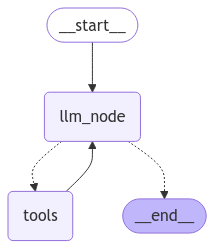

In [43]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(sql_agent.get_graph(xray=1).draw_mermaid_png()))

In [44]:
config = {"configurable": {"thread_id": "1"}}
sql_agent.update_state(config=config, values={"messages": system_message_sql_agent})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efabf05-bc31-66e2-8000-b02be97e47f3'}}

In [45]:
from langchain_core.messages import HumanMessage

def stream_graph_updates(graph, user_input: str, config):
    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
    )
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(sql_agent, user_input, config=config)
    except:
        print("Invalid Input!")
        break

================================ Human Message =================================

Hi! My name is Tariq.
================================== Ai Message ==================================

Hello Tariq! How can I assist you today? If you have any questions regarding the database or need help with something specific, feel free to ask!
================================ Human Message =================================

List down all the tables in db.
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_OLfKXhiIjebr9Jr8LBiEVbLJ)
 Call ID: call_OLfKXhiIjebr9Jr8LBiEVbLJ
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

customers, deliverypersonnel, feedbackcomplaints, fooditems, orderitems, orders, payments, restaurants
================================== Ai Message ==================================

The tables in the database are as follows:

1. customers
2. delivery

In [21]:
from langchain_core.messages import AIMessage
snapshot = sql_agent.get_state(config=config)
for message in snapshot.values["messages"]:
    if message.type in ['ai', 'human'] and 'tool_calls' not in message.additional_kwargs:
        message.pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today? If you have any questions about the database or need information, feel free to ask!
================================ Human Message =================================

list down table names
================================== Ai Message ==================================

The tables in the database are as follows:

1. customers
2. deliverypersonnel
3. feedbackcomplaints
4. fooditems
5. orderitems
6. orders
7. payments
8. restaurants

If you need information from any specific table, just let me know!


In [ ]:
# Conversation 1: Order Status and Details
order_status_details = [
    "Hi, my name is Umar Siddiqui and my CustomerID is 7. Can you check the status of my latest order?",
    "How much did I spend on my last order?",
    "What items did I order last time?",
    "Who is delivering my order, and how can I contact them?",
    "Are there any pending payments on my order?",
    "What’s the expected delivery time for my current order?",
    "Can I add special instructions to my ongoing order?",
    "Is there a way to add or change items in my order now?"
]

config = {"configurable": {"thread_id": "2"}}
sql_agent.update_state(config=config, values={"messages": system_message_sql_agent})
for user_input in order_status_details:
    stream_graph_updates(sql_agent, user_input, config=config)

================================ Human Message =================================

Hi, my name is Umar Siddiqui and my CustomerID is 7. Can you check the status of my latest order?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_oiFwcCBlpvIN1BXnOgHpTHtr)
 Call ID: call_oiFwcCBlpvIN1BXnOgHpTHtr
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

customers, deliverypersonnel, feedbackcomplaints, fooditems, orderitems, orders, payments, restaurants
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_kgMkjuk5N63U452HJOS1tRX0)
 Call ID: call_kgMkjuk5N63U452HJOS1tRX0
  Args:
    table_names: customers, orders
  sql_db_schema (call_vnQw5rcOeod76J1pO9FJPVRy)
 Call ID: call_vnQw5rcOeod76J1pO9FJPVRy
  Args:
    table_names: orderitems
================================= Tool Message =====================

In [ ]:

# Conversation 2: Account and Loyalty Points
account_loyalty_points = [
    "How many loyalty points do I have?",
    "Can you tell me when I last earned loyalty points?",
    "What’s my current address on file?",
    "How can I update my payment information?",
    "Can I redeem loyalty points on my next order?",
    "What’s my account’s email address?",
    "How do I reset my password?",
    "How often can I earn loyalty points?"
]

# Conversation 3: Payment and Billing Queries
payment_billing_queries = [
    "What payment method did I use for my last order?",
    "Are there any pending payments I need to clear?",
    "Can I change my payment method for an ongoing order?",
    "How do I view all my past transactions?",
    "Did I pay using Visa or JazzCash last time?",
    "Can I add a new credit card to my account?",
    "Why did my last payment fail?",
    "How can I get a receipt for my last purchase?"
]

# Conversation 4: Restaurant Information and Availability
restaurant_info_availability = [
    "What are the operating hours of Lahore Tikka House?",
    "Is there a restaurant that serves Afghani cuisine nearby?",
    "Which restaurants have the best rating?",
    "Are there any dessert options at Quetta Sajji House?",
    "Can you list all the restaurants available in Karachi?",
    "What type of food does Islamabad Café serve?",
    "Is there a place with high ratings that’s open late tonight?",
    "How far is Hyderabad Biryani Corner from my location?"
]

# Conversation 5: Food and Menu Queries
food_menu_queries = [
    "What’s on the menu at Karachi Broast?",
    "How much does a Beef Biryani cost at Hyderabad Biryani Corner?",
    "Can you suggest something spicy from Lahore Tikka House?",
    "Do any restaurants offer vegetarian options?",
    "What are the most popular items at Peshawar Chapli Kebab?",
    "Can I get a dessert recommendation from Islamabad Café?",
    "How many items does the Quetta Sajji House menu have?",
    "Are there any appetizers in the Pakistani cuisine options?"
]

# Conversation 6: Delivery Information
delivery_information = [
    "Who’s delivering my order right now?",
    "When should I expect my delivery?",
    "Can you provide contact details for the delivery person?",
    "Where is my delivery currently?",
    "What address is my order being delivered to?",
    "Is there a way to track the delivery in real-time?",
    "Has the delivery personnel started the delivery yet?",
    "Can I change the delivery address after placing the order?"
]

# Multi-Agent

In [80]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class RouterState(TypedDict):
    messages: Annotated[list, add_messages]
    route: Literal["database", "other", "tool_call"]


class Router(TypedDict):
    route: Literal["database", "other", "tool_call"]


router_tools = [tools["sql_db_list_tables"], tools["sql_db_schema"]]
router_llm = llm.bind_tools(router_tools).with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "You will act as an expert routing agent where your job is to carefully analyze the user question and route it to one of the specialized agents in the team. You have access to tools for interacting with the database that you can execute to get more context about the connected SQL database. To start, you should ALWAYS look at the tables in the database to see what data is available in the database. Do NOT skip this step. Then you should query the schema of the most relevant tables if you need more context. After processing all this context, you should decide whether the user question can be answered by the SQL agent or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_llm.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    system_message = "You are a helpful AI assistant. Answer the user questions."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def route_after_prediction(state: RouterState,) -> Literal["sql_agent_node", "normal_llm_node", "tools"]:
    if state["route"] == "database":
        return "sql_agent_node"
    elif state["route"] == "tool_call":
        return "tools"
    else:
        return "normal_llm_node"

graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("sql_agent_node", sql_agent)
graph.add_node("tools", ToolNode(router_tools))

graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("tools", "router_node")
graph.add_edge("normal_llm_node", END)
graph.add_edge("sql_agent_node", END)

graph = graph.compile(checkpointer=memory)

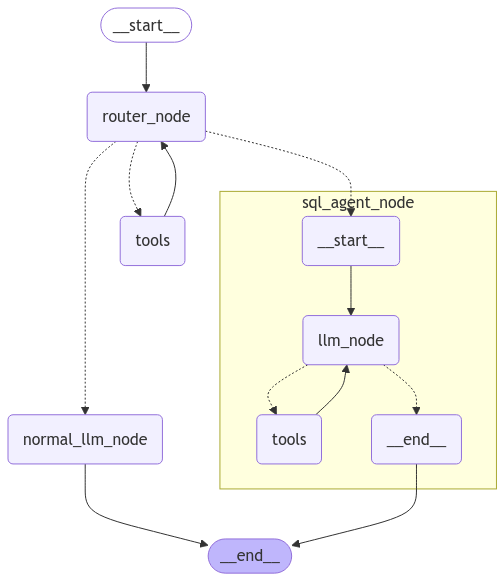

In [81]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [82]:
config = {"configurable": {"thread_id": "11"}}

inputs = {"messages": [{"role": "user", "content": "Hello! Tell me a joke."}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

inputs = {"messages": [{"role": "user", "content": "what is the status of order number 3?"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

inputs = {"messages": [{"role": "user", "content": "What do you know about FoodPanda?"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Sure! Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 30, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3de1288069', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb178038-7ba6-4513-80fe-c2c420763307-0', usage_metadata={'input_tokens': 30, 'output_tokens': 20, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'router_node': {'route': 'database'}}
{'sql_agent_node': {'messages': [HumanMessage(content='Hello! Tell me a joke.'

In [83]:
graph.get_state(config=config).values

{'messages': [HumanMessage(content='Hello! Tell me a joke.', additional_kwargs={}, response_metadata={}, id='6cea2204-7a89-4f7a-9cb4-071fd16bb1f2'),
  AIMessage(content='Sure! Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 30, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3de1288069', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb178038-7ba6-4513-80fe-c2c420763307-0', usage_metadata={'input_tokens': 30, 'output_tokens': 20, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='what is the st